# Wine Classifier
## Data Modeling

### Table of Contents

1. [Data Preparation](#preparation)
    1. [Load the data](#load)
    2. [Prepare the data](#prepare)
2. [Data Modeling](#modeling)
    1. [Train and test split](#split)
    2. [Classification](#classification)
    3. [Model Evaluation](#evaluation)
    4. [Feature Importance](#feature_importance)
3. [Data Modeling - Using PCA](#modeling_pca)
    1. [PCA](#pca)
    2. [Train and test split](#split_pca)
    3. [Classification](#classification_pca)
    4. [Model Evaluation](#evaluation_pca)
4. [Export the results](#export)

In [1]:
# Imports
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import seaborn as sns
from IPython.display import display, Markdown as md
from sklearn.decomposition import PCA
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.preprocessing import MinMaxScaler


# Config
%matplotlib notebook
pd.options.display.max_columns = None

## Data Preparation <a id="preparation"></a>
### Load the data <a id="load"></a>
Loads *.csv* file into *pandas DataFrame*

In [76]:
features = ["label", "alcohol", "malic_acid", "ash", "ash_alcalinity", "magnesium", "phenols", "flavanoids", 
            "nonflavanoid_phenols", "proanthocyanins", "color_intensity", "hue", "od280_od315", "proline"]
df = pd.read_csv("data/raw/wine.csv", names=features)

### Prepare the data <a id="prepare"></a>

In [77]:
# Define 'target' and 'features'
target = "label"
features = df.columns.values
features = features[features != target]

X = df.loc[:, features]
y = df.loc[:, [target]]

display("X shape: {0}".format(X.shape))
display("y shape: {0}".format(y.shape))

'X shape: (178, 13)'

'y shape: (178, 1)'

## Data Modeling<a id="modeling"></a>
### Train and test split <a id="split"></a>
Splits the dataset into a *train set* (80%) and *test set* (20%)

In [78]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

display(md("*X_train* shape: {0} - *X_test* shape: {1}".format(X_train.shape, X_test.shape)))
display(md("*y_train* shape: {0} - *y_test* shape: {1}".format(y_train.shape, y_test.shape)))

*X_train* shape: (142, 13) - *X_test* shape: (36, 13)

*y_train* shape: (142, 1) - *y_test* shape: (36, 1)

### Classification<a id="classification"></a>

In [79]:
classifier_names = [
    "Logistic Regression",
    "Decision Tree Classifier",
    "Random Forest Classifier",
    "Voting Classifier"
]

log_reg_clf = LogisticRegression(solver="lbfgs", multi_class="multinomial", max_iter=10000)
dec_tre_clf = DecisionTreeClassifier(max_depth=5)
rnd_for_clf = RandomForestClassifier(max_depth=5, n_estimators=10, max_features=1)
vot_clf = VotingClassifier(estimators=[("log_reg", log_reg_clf), ("dec_tre", dec_tre_clf), ("rnd_for", rnd_for_clf)])

classifier_models = [
    log_reg_clf,
    dec_tre_clf,
    rnd_for_clf,
    vot_clf
]

In [80]:
predictions = []
for clf_model in classifier_models:
    clf_model.fit(X_train, y_train.values.ravel())
    predictions.append(clf_model.predict(X_test))

### Model Evaluation<a id="evaluation"></a>

In [81]:
model_metrics = []
for clf_name, prediction in zip(classifier_names, predictions):
    model_metrics.append([
        clf_name,
        accuracy_score(y_test, prediction),
        recall_score(y_test, prediction, average="weighted"),
        precision_score(y_test, prediction, average="weighted"),
        f1_score(y_test, prediction, average="weighted")
    ])
    
model_summary = pd.DataFrame(model_metrics, columns=['Model','Accuracy','Presicion','Recall','F1'])

display(model_summary)

,Model,Accuracy,Presicion,Recall,F1
0,Logistic Regression,1.000000,1.000000,1.000000,1.000000
1,Decision Tree Classifier,0.944444,0.944444,0.946296,0.943997
2,Random Forest Classifier,0.972222,0.972222,0.974074,0.971775
3,Voting Classifier,1.000000,1.000000,1.000000,1.000000


### Feature Importance<a id="feature_importance"></a>
Random Forest provides an estimate of a feature's importance by computing the average depth at which it appears across all trees in the forest.

In this case, **color_intensity** and **hue** seems to be the most important features.

In [82]:
feature_importance_df = pd.DataFrame(data={"feature": features, "score": rnd_for_clf.feature_importances_})
display(feature_importance_df.sort_values(by="score", ascending=False))

,feature,score
11,od280_od315,0.150377
6,flavanoids,0.123463
4,magnesium,0.111077
9,color_intensity,0.101241
10,hue,0.081027
5,phenols,0.072578
8,proanthocyanins,0.066262
2,ash,0.064293
3,ash_alcalinity,0.056300
1,malic_acid,0.052272


## Data Modeling - Using PCA<a id="modeling_pca"></a>
### PCA<a id="pca"></a>

c:\users\matias\miniconda3\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


'Variance ratio for each dimension: [40.74948456 18.97035178]'

<IPython.core.display.Javascript object>


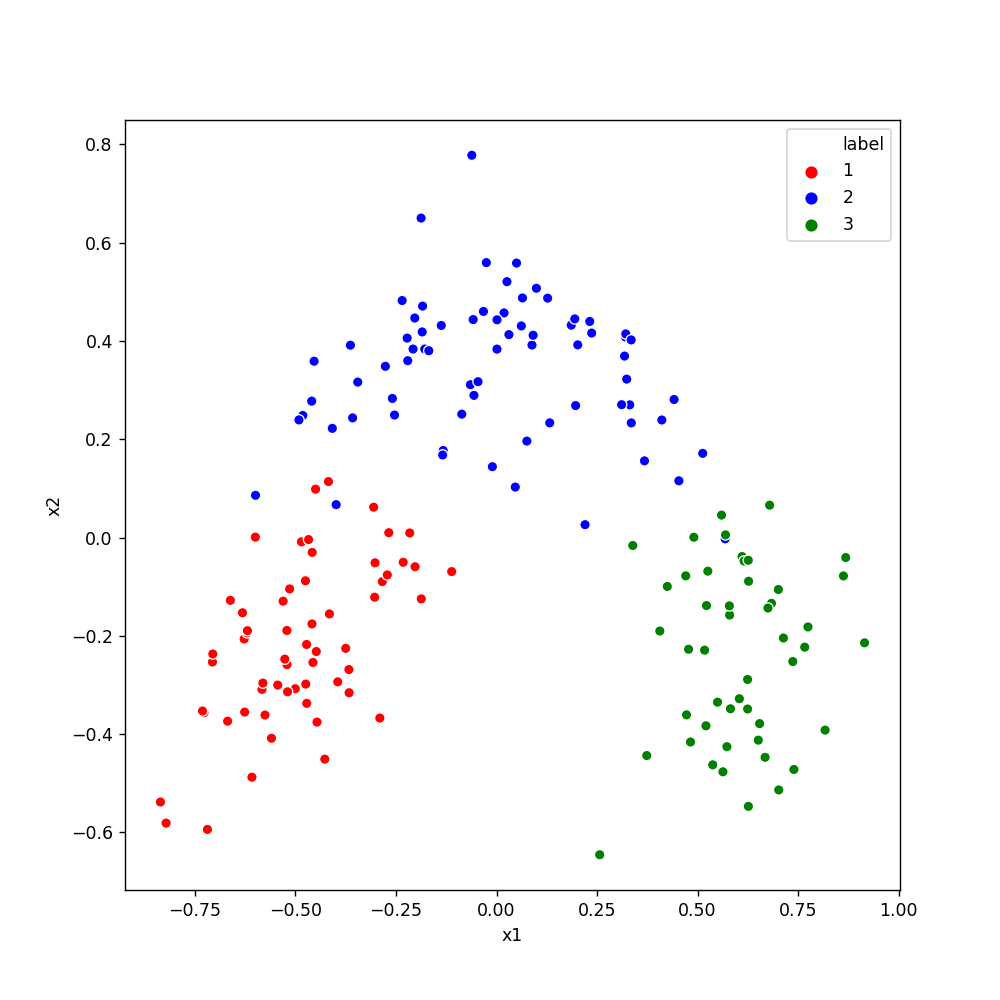

In [83]:
# First we scale features between (0,1)
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)

# Apply PCA to reduce to 2 dimensions
pca = PCA(n_components=2)
X_2d = pca.fit_transform(X_scaled)

display("Variance ratio for each dimension: {0}".format(pca.explained_variance_ratio_ * 100))

# Create new DataFrame ('X_2d_df') with the reduced data and the labels
labels = y["label"].astype("str")
X_2d_df = pd.DataFrame(data={"x1": X_2d[:, 0], "x2": X_2d[:, 1], "label": labels})

fig_scatter, ax_scatter = plt.subplots(figsize=(8,8))
sns.scatterplot(data=X_2d_df, x="x1", y="x2", hue="label",  palette=["r", "b", "g"], ax=ax_scatter)

### Train and test split<a id="split_pca"></a>

In [84]:
X_2d_train, X_2d_test, y_train, y_test = train_test_split(X_2d, y, test_size=0.2, random_state=42)

display(md("*X_train* shape: {0} - *X_test* shape: {1}".format(X_2d_train.shape, X_2d_test.shape)))
display(md("*y_train* shape: {0} - *y_test* shape: {1}".format(y_train.shape, y_test.shape)))

*X_train* shape: (142, 2) - *X_test* shape: (36, 2)

*y_train* shape: (142, 1) - *y_test* shape: (36, 1)

### Classification<a id="classification_pca"></a>

In [85]:
log_reg_clf = LogisticRegression(solver="lbfgs", multi_class="multinomial", max_iter=10)
log_reg_clf.fit(X_2d_train, y_train)

predictions = log_reg_clf.predict(X_2d_test)

c:\users\matias\miniconda3\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\users\matias\miniconda3\lib\site-packages\sklearn\linear_model\logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


<IPython.core.display.Javascript object>


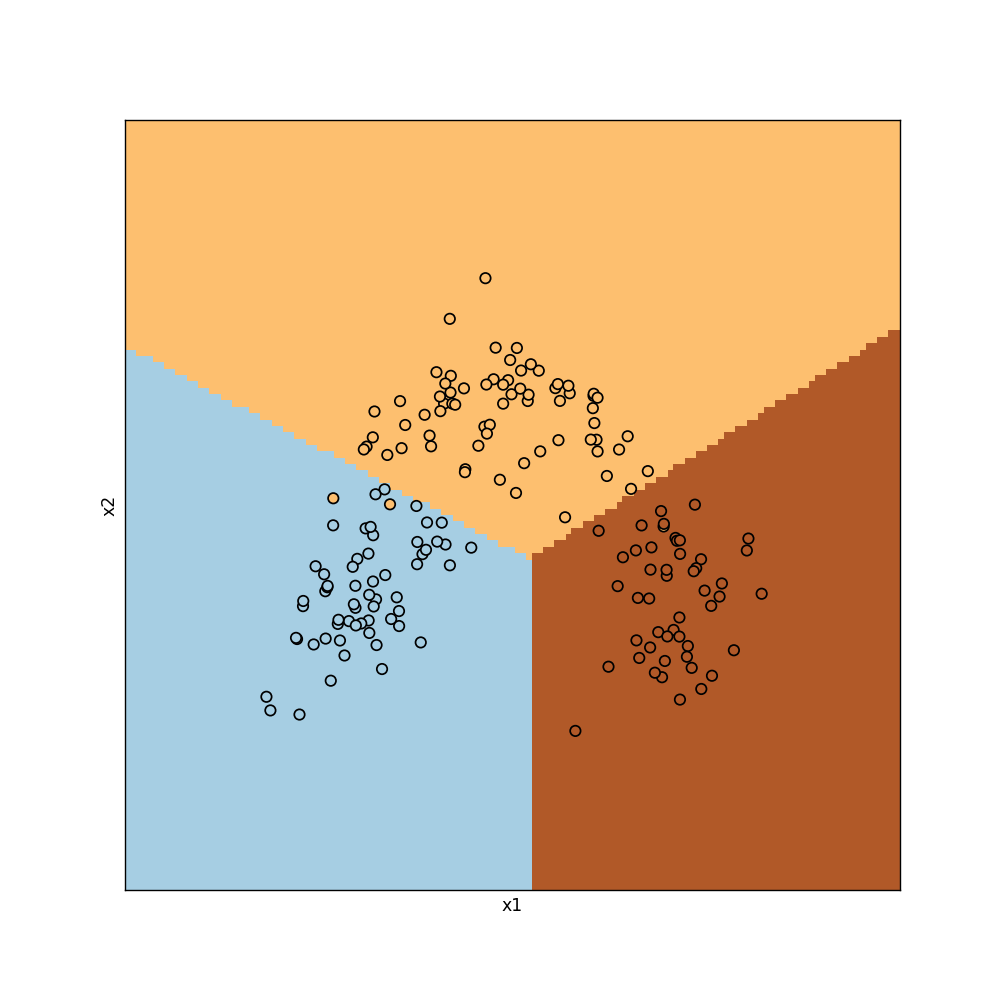

In [86]:
# Plot the decision boundary
x_min, x_max = X_2d[:, 0].min() - .5, X_2d[:, 0].max() + .5
y_min, y_max = X_2d[:, 1].min() - .5, X_2d[:, 1].max() + .5
h = .02  # step size in the mesh
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
Z = log_reg_clf.predict(np.c_[xx.ravel(), yy.ravel()])

# Put the result into a color plot
Z = Z.reshape(xx.shape)
fig_dec_bou, ax_dec_bou = plt.subplots(figsize=(8,8))
plt.pcolormesh(xx, yy, Z, cmap=plt.cm.Paired)

# Plot also the training points
plt.scatter(X_2d[:, 0], X_2d[:, 1], c=y.values.ravel(), edgecolors='k', cmap=plt.cm.Paired)
plt.xlabel("x1")
plt.ylabel("x2")

plt.xlim(xx.min(), xx.max())
plt.ylim(yy.min(), yy.max())
plt.xticks(())
plt.yticks(())

plt.show()

### Model evaluation<a id="evaluation_pca"></a>

In [87]:
display("Accuracy: {0}".format(accuracy_score(y_test, predictions)))
display("Recall: {0}".format(recall_score(y_test, predictions, average="weighted")))
display("Precision: {0}".format(precision_score(y_test, predictions, average="weighted")))
display("F1: {0}".format(f1_score(y_test, predictions, average="weighted")))

'Accuracy: 1.0'

'Recall: 1.0'

'Precision: 1.0'

'F1: 1.0'

## Export the results<a id="export"></a>

In [88]:
#TODO: this!